In [ ]:
import torch
import torchvision.models as models
# from modules.classifier import Classifier

from modules.preprocessing import BRATSDataModule
from modules.autoencoders import HamiltonianAutoencoder
from omegaconf import OmegaConf
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


cfg = OmegaConf.load('config.yaml')

# model = HamiltonianAutoencoder(**cfg.autoencoder)
model = HamiltonianAutoencoder.load_from_checkpoint('./checkpoints/n4uattxw.ckpt')

In [25]:
from tqdm import tqdm
fake_data = []

for _ in tqdm(range(100), position=0, leave=True):
    fake_data.append(model.sample_img(n_samples=10).detach().cpu().numpy())

fake_data = np.concatenate(fake_data, axis=0)

# selecting only those with tumor size > 150
fake_data = fake_data[fake_data[:, 1, ...].sum(axis=(1, 2)) > 150]

fake_data.shape

100%|██████████| 100/100 [00:02<00:00, 33.35it/s]


(387, 2, 128, 128)

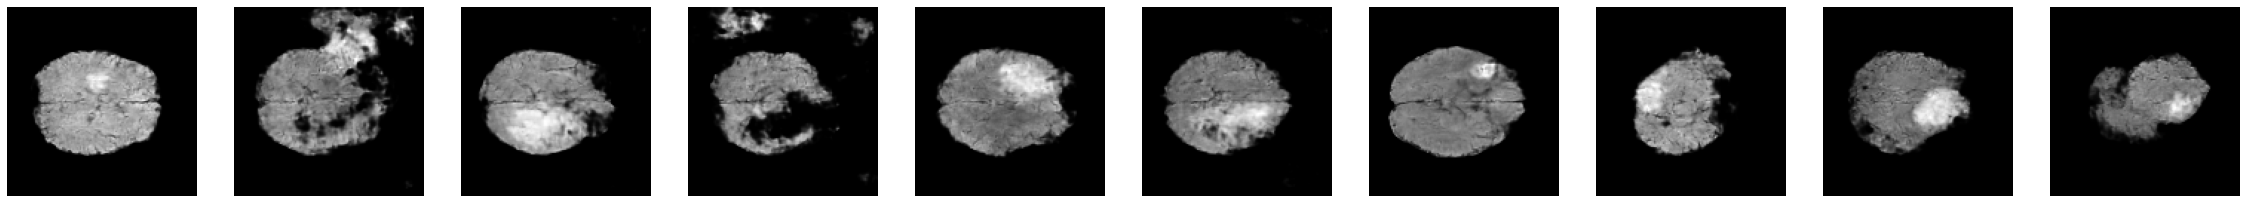

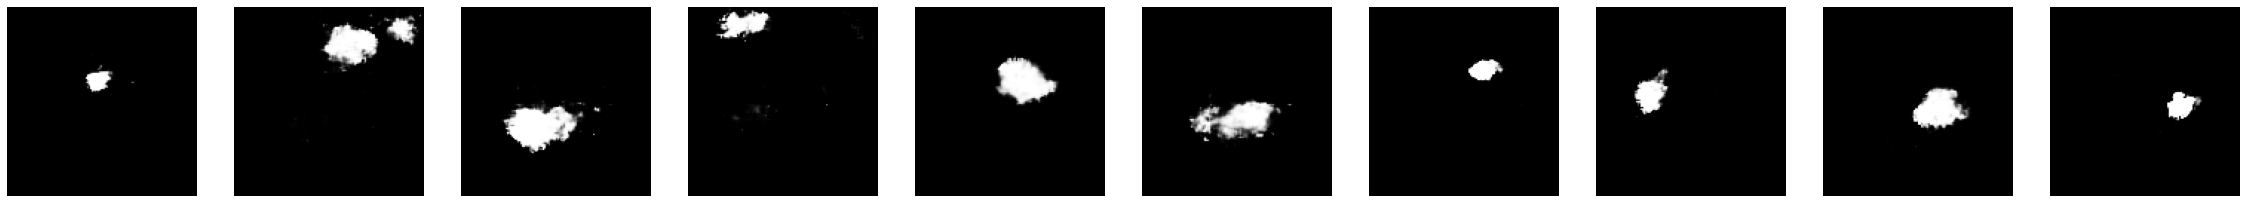

In [31]:
import matplotlib.pyplot as plt

rand_idx = np.random.randint(0, fake_data.shape[0], size=10)

plt.figure(figsize=(40, 20))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake_data[rand_idx[i], 0, ...], cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(40, 20))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake_data[rand_idx[i], 1, ...], cmap='gray')
    plt.axis('off')
plt.show()

In [5]:
import numpy as np
import cv2 as cv

from modules.preprocessing import BRATSDataModule
from omegaconf import OmegaConf

cfg = OmegaConf.load('config.yaml')

br = BRATSDataModule(**cfg.data)
br.prepare_data()
br.setup()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...


100%|██████████| 32000/32000 [00:04<00:00, 6977.15it/s]


Max tumor size: 1878.0, Slices per level: 88, Bins: 72


100%|██████████| 71/71 [00:13<00:00,  5.29it/s]


Train shape: torch.Size([4112, 2, 128, 128])
Min: 0.0, Max: 1.0


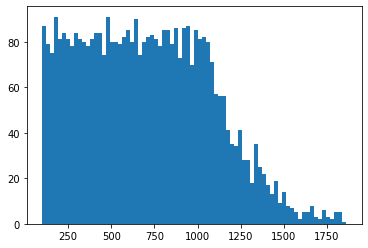

In [3]:
import matplotlib.pyplot as plt

intensities = br.train_dataset.data[0][:, 1].sum(dim=(1, 2))
plt.hist(intensities, bins=76)
plt.show()

In [31]:
from tqdm import tqdm

data = torch.from_numpy(np.load('./data/brats_preprocessed.npy'))
data = data.permute(0, 4, 1, 2, 3) # depth first

# switching to 2D
D, W, H = (64, 128, 128)
data = data.reshape(data.shape[0] * D, -1, W, H)

print(data.shape, data.min(), data.max())
print(data[60, 0].max(), data[60, 0].min())

# normalize the data [0, 1] example by example (only images)
for idx in tqdm(range(data.shape[0])):
    if data[idx, 0].max() != 0:
        data[idx, 0] = (data[idx, 0] - data[idx, 0].min()) / (data[idx, 0].max() - data[idx, 0].min())

print(data.shape, data.min(), data.max())

torch.Size([32000, 2, 128, 128]) tensor(-15.0959, dtype=torch.float64) tensor(471385.8438, dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)


100%|██████████| 32000/32000 [00:03<00:00, 8051.54it/s]


torch.Size([32000, 2, 128, 128]) tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


In [34]:
data.view(32000, -1).max(dim=1)[0].sum()

tensor(28955., dtype=torch.float64)

In [16]:
x = torch.randn(10, 2, 128, 128)

x[:, 1].sum(dim=(1, 2)).max()

tensor(145.5397)

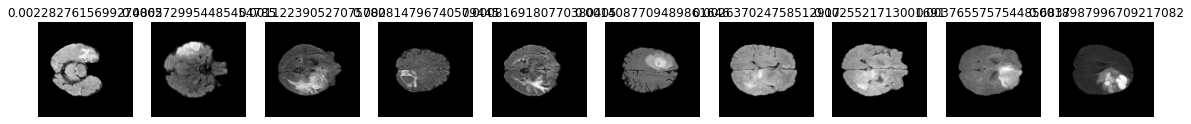

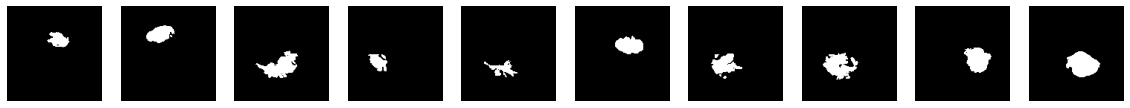

In [19]:
import matplotlib.pyplot as plt

rand_idx = torch.randint(0, len(br.train_x), (10,))

plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(br.train_x[rand_idx[i], 0, :, :], cmap='gray')
    plt.title(br.train_x[rand_idx[i], 0, ...].max().item())
    plt.axis('off')
plt.show()

plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(br.train_x[rand_idx[i], 1, :, :], cmap='gray')
    plt.axis('off')
plt.show()

In [21]:
br.train_x[:, 0].max()

tensor(0.0171, dtype=torch.float64)

In [9]:
import numpy as np

data = np.load('./data/brats_preprocessed.npy')
data.shape

(500, 2, 128, 128, 64)

In [2]:
intens = []
for idx in range(br.data.shape[0]):
    intens.append(br.data[idx, 1].sum().item())

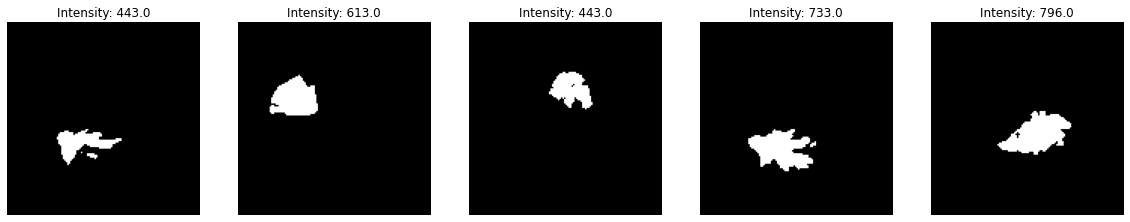

In [3]:
import numpy as np
import matplotlib.pyplot as plt

rand_idx = np.random.randint(0, br.data.shape[0], size=(5,))

plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(br.data[rand_idx[i], 1], cmap='gray')
    plt.axis('off')
    plt.title(f'Intensity: {br.data[rand_idx[i], 1].sum()}')
plt.show()

(array([44., 40., 41., 40., 32., 42., 36., 42., 30., 28., 29., 31., 31.,
        30., 26., 24., 43., 37., 22., 25., 29., 16., 20., 21., 21., 25.,
        31., 16., 13., 17., 10.,  9., 10., 13., 10.,  8.,  3.,  5.,  9.,
         7.,  4.,  1.,  4.,  5.,  3.,  3.,  3.,  1.,  2.,  3.]),
 array([ 151.  ,  179.24,  207.48,  235.72,  263.96,  292.2 ,  320.44,
         348.68,  376.92,  405.16,  433.4 ,  461.64,  489.88,  518.12,
         546.36,  574.6 ,  602.84,  631.08,  659.32,  687.56,  715.8 ,
         744.04,  772.28,  800.52,  828.76,  857.  ,  885.24,  913.48,
         941.72,  969.96,  998.2 , 1026.44, 1054.68, 1082.92, 1111.16,
        1139.4 , 1167.64, 1195.88, 1224.12, 1252.36, 1280.6 , 1308.84,
        1337.08, 1365.32, 1393.56, 1421.8 , 1450.04, 1478.28, 1506.52,
        1534.76, 1563.  ]),
 <BarContainer object of 50 artists>)

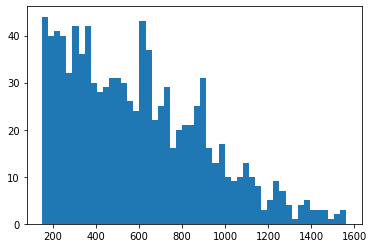

In [4]:
plt.hist(intens, bins=50)

Point essentiels :
- L'évaluation a été menée sur l'ensemble de données BRATS 2021.
- Les performances ont été évaluées en utilisant la métrique Dice (DSC).
- L'ensemble de référence est composé de 100 patients seulement.
- L'ensemble d'apprentissage final a été augmenté avec 100, 200, 300 et 500 images synthétiques.

In [1]:
from modules.preprocessing import BRATSDataModule
from omegaconf import OmegaConf

cfg = OmegaConf.load('./config.yaml')

br = BRATSDataModule(**cfg.data)
br.prepare_data()
br.setup()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...
Train shape: torch.Size([1343, 2, 128, 128])
Test shape: torch.Size([0, 2, 128, 128])
Min: 0.0, Max: 1.0


In [3]:
from tqdm import tqdm
import numpy as np

loader = br.val_dataloader()
model = model.to(device)
model.eval()

preds, targets = [], []
with torch.no_grad():
    for x, _, y in tqdm(loader):
        x, y = x[:, 0, None, ...].to(device, dtype=torch.float32), y.to(device, dtype=torch.long)
        pred = model(x)
        preds.append(pred.argmax(dim=1).cpu().numpy())
        targets.append(y.cpu().numpy())

preds = np.concatenate(preds)
targets = np.concatenate(targets)

  0%|          | 0/825 [00:00<?, ?it/s]

100%|██████████| 825/825 [00:09<00:00, 86.49it/s] 


In [8]:
# accuracy
print(f'Accuracy: {np.mean(preds == targets)}')

Accuracy: 0.9851380042462845


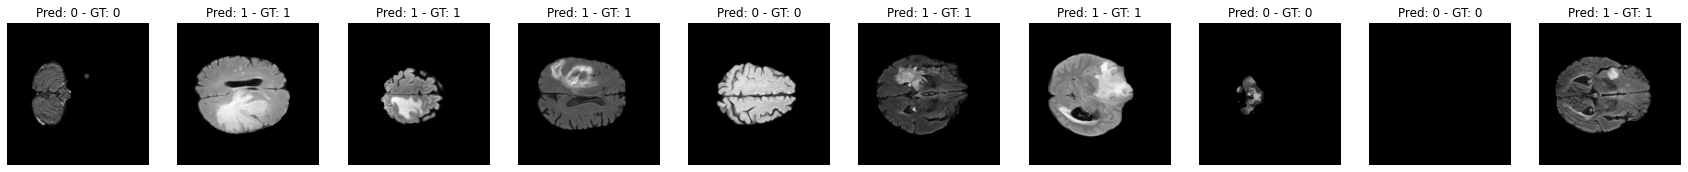

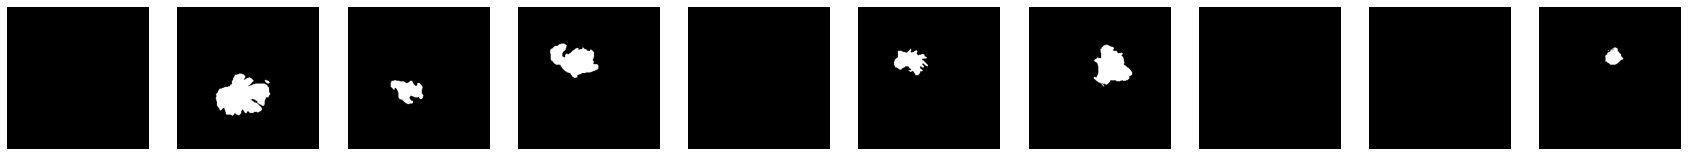

In [27]:
import matplotlib.pyplot as plt

# plotting tests
x_test, _, y_test = loader.dataset.data

# selecting 10 samples randomly
idx = np.random.choice(x_test.__len__(), 10)
rdn_x, rdn_y = x_test[idx], y_test[idx]

rdn_x = rdn_x.to(device, dtype=torch.float32)
rdn_y = rdn_y.to(device, dtype=torch.long)

rdn_pred = model(rdn_x[:, 0, None, ...]).argmax(dim=1).cpu().numpy()

plt.figure(figsize=(30, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(rdn_x[i, 0, ...].cpu().numpy(), cmap='gray')
    plt.title(f'Pred: {rdn_pred[i]} - GT: {rdn_y[i]}')
    plt.axis('off')
plt.show()

plt.figure(figsize=(30, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(rdn_x[i, 1, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
from omegaconf import OmegaConf
from torchsummary import summary

from modules.autoencoders import HamiltonianAutoencoder
from modules.preprocessing import BRATSDataModule

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = OmegaConf.load('./config.yaml')

hvae = HamiltonianAutoencoder(**cfg.autoencoder).to(device)

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [2]:
hvae.on_train_start()

In [3]:
x = torch.randn(4, 2, 128, 128).to(device, dtype=torch.float32)
pos = torch.randint(0, 64, (4,)).to(device, dtype=torch.long)
y = torch.randint(0, 2, size=(4,)).to(device, dtype=torch.long)
y = torch.nn.functional.one_hot(y, num_classes=2).to(device, dtype=torch.float32)

o = hvae(x, pos, y)

In [4]:
br = BRATSDataModule(**cfg.data)
br.prepare_data()
br.setup()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...
Train shape: torch.Size([38400, 2, 128, 128])
Test shape: torch.Size([0, 2, 128, 128])
Train slice positions shape: torch.Size([38400])
Test slice positions shape: torch.Size([0])
Train has mask shape: torch.Size([38400, 2])
Test has mask shape: torch.Size([0, 2])
Min: 0.0, Max: 1.0


In [5]:
batch = next(iter(br.train_dataloader()))
print(batch[0].shape, batch[0][:, 0, ...].max(), batch[0][:, 0, ...].min())
print(torch.unique(batch[0][:, 1, ...]))

print(batch[1].shape, batch[1].max(), batch[1].min())
print(torch.unique(batch[2]))

torch.Size([8, 2, 128, 128]) tensor(0.7355, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor([0., 1.], dtype=torch.float64)
torch.Size([8]) tensor(63) tensor(10)
tensor([0., 1.])


In [6]:
img, pos, y = batch
img = img.to(device, dtype=torch.float32)
pos = pos.to(device, dtype=torch.long)
y = y.to(device, dtype=torch.float32)
n = torch.randn(8, 512).to(device, dtype=torch.float32)

In [7]:
rec_img = img.clone()
rec_img[:, 1, ...] = 0

In [10]:
hvae.loss_function(img, rec_img, n, n, n, n)

tensor(44496.2656, device='cuda:0')

In [4]:
hvae.positional_encoder.embedding.device

device(type='cuda', index=0)

In [3]:
hvae = hvae.to(device)
hvae.sample_img()

tensor([[[[0.5018, 0.4930, 0.5086,  ..., 0.4966, 0.4953, 0.4952],
          [0.4996, 0.4980, 0.5218,  ..., 0.5182, 0.5019, 0.4901],
          [0.5095, 0.4963, 0.5071,  ..., 0.4771, 0.4925, 0.4830],
          ...,
          [0.4895, 0.5203, 0.5200,  ..., 0.5108, 0.5101, 0.5065],
          [0.5028, 0.5048, 0.5127,  ..., 0.5141, 0.4970, 0.5121],
          [0.5007, 0.5089, 0.5127,  ..., 0.5045, 0.5128, 0.4885]],

         [[0.5091, 0.5033, 0.5147,  ..., 0.5157, 0.5079, 0.5119],
          [0.5033, 0.5210, 0.5112,  ..., 0.5104, 0.5072, 0.4937],
          [0.5077, 0.4876, 0.5043,  ..., 0.5161, 0.5070, 0.5200],
          ...,
          [0.4992, 0.5152, 0.5092,  ..., 0.4907, 0.5204, 0.5031],
          [0.5123, 0.4856, 0.5177,  ..., 0.5077, 0.5169, 0.5041],
          [0.5086, 0.5042, 0.4993,  ..., 0.5193, 0.5004, 0.5039]]]],
       device='cuda:0')

In [25]:
import torch

data = dataset[0]  # Your dataset of shape N, 2, 128, 128
mask = data[:, 1, :, :]
nonzero_mask = torch.sum(mask, dim=(1, 2)) > 0
has_mask = nonzero_mask.int()

print(has_mask)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


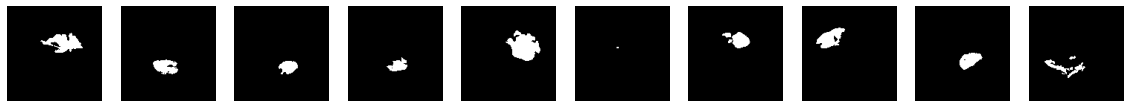

In [37]:
import matplotlib.pyplot as plt

rand_empty = np.random.choice(np.where(has_mask == 1)[0], size=(10,))

plt.figure(figsize=(20, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(data[rand_empty[i], 1, ...], cmap='gray')
    plt.axis('off')

plt.show()

In [2]:
x = torch.randn(4, 1, 128, 128).to(device)
pos = torch.randint(0, 64, size=(4,)).to(device, dtype=torch.long)

recon_x, z, z0, rho, eps0, gamma, mu, log_var = hvae(x, pos)

In [11]:
data = np.load('./data/brats_preprocessed.npy')

In [12]:
# norm between 0 and 1
data = (data - data.min()) / (data.max() - data.min())

In [14]:
data.max()

1.0

In [2]:
from modules.preprocessing import BRATSDataModule


datamodule = BRATSDataModule(**cfg.data)
datamodule.prepare_data()
datamodule.setup()
loader = datamodule.train_dataloader()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...
Train shape: torch.Size([10880, 2, 128, 128])
Test shape: torch.Size([1920, 2, 128, 128])
Train slice positions shape: torch.Size([10880])
Test slice positions shape: torch.Size([1920])
Min: 0.0, Max: 1.0


In [10]:
g = hvae.sample_img(n_samples=1)

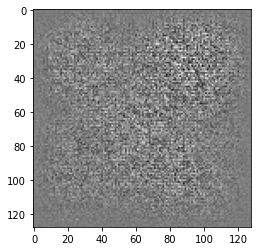

In [16]:
import matplotlib.pyplot as plt

plt.imshow((g[0, 0, ...].detach().cpu().numpy() * 255).astype(np.uint8), cmap='gray')

In [20]:
hvae.eval()
generated = hvae.sample_img(n_samples=5)

# channel wise grid
img_grid = torch.cat([ 
    torch.hstack([img for img in generated[:, idx, ...]])
    for idx in range(generated.shape[1])
], dim=0)

img_grid = img_grid.unsqueeze(-1).detach().cpu().numpy()
img_grid = (img_grid * 255).astype(np.uint8) # denormalize

print(img_grid.shape)

(256, 640, 1)


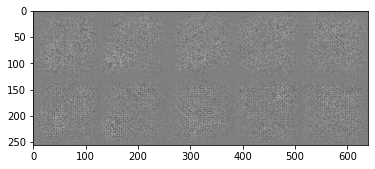

In [19]:
plt.imshow(img_grid, cmap='gray')

In [1]:
from modules.autoencoders import HamiltonianAutoencoder

hvae = HamiltonianAutoencoder.load_from_checkpoint('./ckpt-epoch=9.ckpt')

/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.3, which is newer than your current Lightning version: v2.0.2
  rank_zero_warn(


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hvae = hvae.to(device)
hvae.positional_encoder.embedding = hvae.positional_encoder.embedding.to(device)
g = hvae.sample_img(n_samples=1, pos=torch.tensor([20]).to(device))

# import numpy as np
# import matplotlib.pyplot as plt
# plt.imshow((g[0, 0, ...].detach().cpu().numpy() * 255).astype(np.uint8), cmap='gray')

In [16]:
from modules.preprocessing import BRATSDataModule

br = BRATSDataModule(**cfg.data)

tensor(0.0767, device='cuda:0')

In [25]:
br.prepare_data()
br.setup()

Dataset already exists at ./data/brats_preprocessed.npy
Loading dataset from npy file...
Train shape: torch.Size([10880, 2, 128, 128])
Test shape: torch.Size([1920, 2, 128, 128])
Train slice positions shape: torch.Size([10880])
Test slice positions shape: torch.Size([1920])
Min: 0.0, Max: 1.0
